In [ ]:
pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install contractions

In [ ]:
!pip install lime

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import random 
import contractions
import nltk 
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.corpus import wordnet
import string
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
import pickle
from imblearn.over_sampling import SMOTE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/preprocessed.xlsx')

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/preprocessed.xlsx')

In [ ]:
df.head()

NameError: ignored

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308384 entries, 0 to 308383
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   serial   308384 non-null  int64 
 1   comment  308368 non-null  object
 2   label    308384 non-null  object
dtypes: int64(1), object(2)
memory usage: 7.1+ MB


In [ ]:
df=df.dropna()

In [ ]:
df.dtypes

serial      int64
comment    object
label      object
dtype: object

In [ ]:
df.label.astype('category')

0         Postive
1         Postive
2         Postive
3         Postive
4         Postive
           ...   
308379    Postive
308380    Postive
308381    Postive
308382    Postive
308383    Postive
Name: label, Length: 308368, dtype: category
Categories (2, object): ['Negative', 'Postive']

In [ ]:
df.label.dtypes

dtype('O')

In [ ]:
df.groupby('label').count()

,serial,comment
label,,
Negative,37268,37268
Postive,271100,271100


<Axes: >

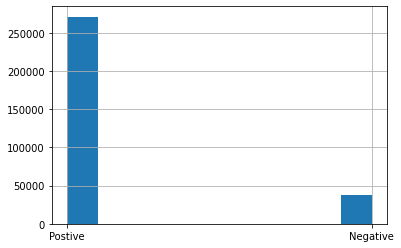

In [ ]:
df['label'].hist()

In [ ]:
df.comment

0         Mohammad harun, he is an awesome guy very info...
1         amazing guy gaurav was, so patience and kind. ...
2         Gaurav was very knowledgeable and very helpful...
3         I called them regarding my flight cancellation...
4         VERY GOOD SERVICE BY GAURAV LOHAT SERVED AS SO...
                                ...                        
308379    You have to double check price before place or...
308380    My reserved flight was just as I expected.  Th...
308381                                Quick easy and cheap.
308382                             Great experience & price
308383    I found the website extremely helpful. I have ...
Name: comment, Length: 308368, dtype: object

In [ ]:
df['comment_length'] = df['comment'].str.split(' ').str.len()

In [ ]:
df[df['comment_length'] < 2].count()

serial            718
comment           718
label             718
comment_length    718
dtype: int64

In [ ]:
text = []
for i in df.index:
    text += str(df['comment'][i]).split()

In [ ]:
word_cloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=STOPWORDS,
        ).generate(str(text))

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


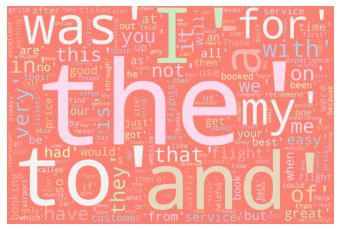

In [ ]:
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [ ]:
df.groupby('label').count()

,serial,comment,comment_length
label,,,
Negative,37268,37268,37268
Postive,271100,271100,271099


In [ ]:
df.head()

,serial,comment,label,comment_length
0,0,"Mohammad harun, he is an awesome guy very info...",Postive,44.0
1,1,"amazing guy gaurav was, so patience and kind. ...",Postive,55.0
2,2,Gaurav was very knowledgeable and very helpful...,Postive,36.0
3,3,I called them regarding my flight cancellation...,Postive,34.0
4,4,VERY GOOD SERVICE BY GAURAV LOHAT SERVED AS SO...,Postive,25.0


In [ ]:
Plabel = df[df['label'] =='Postive']

In [ ]:
Nlabel = df[df['label']=='Negative']

In [ ]:
Plabel.groupby('label').count()

,serial,comment
label,,
Postive,271113,271100


In [ ]:
df1 = pd.concat([Plabel,Nlabel]).sample(frac=1,random_state =2).reset_index()

In [ ]:
df1.groupby('label').count()

,index,serial,comment
label,,,
Negative,37271,37271,37268
Postive,271113,271113,271100


In [ ]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
def text_preproc(x):
  x = re.sub(r'â€™*',"'", x) # Replacing â€™ with ' sign so later the contractions can be removed
  x = contractions.fix(x) # Remove Contractions
  x = x.lower() # Convert the string to lowercase
  x = ' '.join(lemmatizer.lemmatize(word, 'v') for word in x.split()) # changing the word to it's root form
  x = re.sub(r'[^a-z]',' ',x) # Remove any character which is not an aplhabet
  x = re.sub(r'https*\S+', ' ', x) # Removing any https string
  x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x) # Remove Punctuation
  x = re.sub(r'\s{2,}', ' ', x) # Removing multiple spaces
  x = ' '.join([word for word in x.split(' ') if word not in stop_words]) #Remove Stop Words
  return x

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df1['clean_comment'] =  df1['comment'].astype(str).apply(text_preproc)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df1.head()

,Unnamed: 0.1,Unnamed: 0,comment,label,clean_comment,Target
0,0,0,"Mohammad harun, he is an awesome guy very info...",Postive,mohammad harun awesome guy informative helpful...,1
1,1,1,"amazing guy gaurav was, so patience and kind. ...",Postive,amaze guy gaurav patience kind help start end ...,1
2,2,2,Gaurav was very knowledgeable and very helpful...,Postive,gaurav knowledgeable helpful know situation ab...,1
3,3,3,I called them regarding my flight cancellation...,Postive,call regard flight cancellation narrate worrie...,1
4,4,4,VERY GOOD SERVICE BY GAURAV LOHAT SERVED AS SO...,Postive,good service gaurav lohat serve soon reach tra...,1


In [ ]:
Nlabel = df1[df1['label'] =='Negative']

In [ ]:
Nlabel.head()

,index,serial,comment,label,comment_length,clean_comment
4,47538,47538,"When I booked with your website, I expected ta...",Negative,106.0,book website expect take time land check airli...
8,164613,164613,"stop sending me emails, my flight is booked,if...",Negative,29.0,stop send emails flight booked want travel ins...
12,162570,162570,QUICK AND EASY AND CHEAP.,Negative,5.0,quick easy cheap
13,165083,165083,"Friendly people, clean facility, and quick ser...",Negative,11.0,friendly people clean facility quick service b...
15,184279,184279,I called the location 17 times and they did no...,Negative,167.0,call location time answer take cab park lot te...


In [ ]:
Nlabel.sample(n=100)

,index,serial,comment,label,comment_length,clean_comment
16492,298340,298340,Didn't charged the prices shown Overpriced Har...,Negative,11.0,charge price show overprice hard contact phone
99324,15373,15373,I bought an insurance on my flight from Toulou...,Negative,30.0,buy insurance flight toulouse copenhagen back ...
9453,15235,15235,thank for you services,Negative,4.0,thank service
117601,236992,236992,"I needed to add extra baggage to my flight, bu...",Negative,198.0,need add extra baggage flight kiwi use email a...
44152,34022,34022,Sakshi did a great job going over multiple dat...,Negative,57.0,sakshi great job go multiple date requests pol...
...,...,...,...,...,...,...
226925,192256,192256,Cheap flight and mr. Cristy from the Costumer ...,Negative,44.0,cheap flight mr cristy costumer support team k...
272447,177482,177482,Very convenient option. Pricing is affordable....,Negative,43.0,convenient option price affordable take get ca...
85182,111962,111962,My flight got cancelled and changed to tomorro...,Negative,246.0,flight get cancel change tomorrow due weather ...
272707,123327,123327,THIS MY SECOND TIME USING BOOKIT.COM AND BOTH ...,Negative,184.0,second time use bookit com time nothing headac...


In [ ]:
Plabel = df1[df1['label'] =='Postive']
Nlabel = df1[df1['label'] =='Negative']
Ptext = []
Ntext = []
for i in Plabel.index:
    Ptext += str(Plabel['clean_comment'][i]).split()
for i in Nlabel.index:
    Ntext += str(Nlabel['clean_comment'][i]).split()

In [ ]:
Plabel.sample(n=100)

,index,serial,comment,label,comment_length,clean_comment
242084,269355,269355,"Easy process, good flights at the best time to...",Postive,12.0,easy process good flight best time meet needs
278802,222642,222642,Love just fly! Always the greatest deals,Postive,7.0,love fly always greatest deal
5537,173212,173212,"There were a couple of misunderstandings,on my...",Postive,33.0,couple misunderstandings part staff easy talk ...
158831,284970,284970,"One click to get to the site, great prices fou...",Postive,32.0,one click get site great price find direct fli...
72525,187571,187571,I made reservations for parking at the Self pa...,Postive,161.0,make reservations park self park lot seatac wa...
...,...,...,...,...,...,...
145051,120285,120285,Great value and deal.,Postive,4.0,great value deal
47509,59991,59991,"Anmol, is very Helpfull and he is Great Resour...",Postive,30.0,anmol helpfull great resource assist lot quest...
258056,301610,301610,I love that I can go the latest to find the fi...,Postive,17.0,love go latest find first flight ticket cheap
224937,60258,60258,Jaspreet helped me get started with the itener...,Postive,51.0,jaspreet help get start itenerary beginning ru...


/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


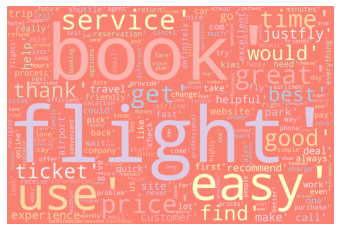

In [ ]:
word_cloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=STOPWORDS,
        ).generate(str(Ptext))

plt.imshow(word_cloud)
plt.axis("off")
plt.show()

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


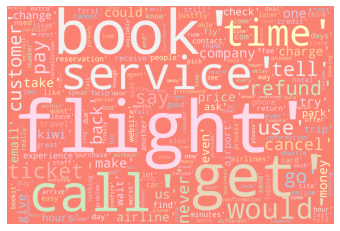

In [ ]:
word_cloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=STOPWORDS,
        ).generate(str(Ntext))

plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [ ]:
target_map = {'Postive':1, 'Negative':0}
df1['Target']= df1['label'].map(target_map)

In [ ]:
df1

,Unnamed: 0.1,Unnamed: 0,comment,label,clean_comment,Target
0,0,0,"Mohammad harun, he is an awesome guy very info...",Postive,mohammad harun awesome guy informative helpful...,1
1,1,1,"amazing guy gaurav was, so patience and kind. ...",Postive,amaze guy gaurav patience kind help start end ...,1
2,2,2,Gaurav was very knowledgeable and very helpful...,Postive,gaurav knowledgeable helpful know situation ab...,1
3,3,3,I called them regarding my flight cancellation...,Postive,call regard flight cancellation narrate worrie...,1
4,4,4,VERY GOOD SERVICE BY GAURAV LOHAT SERVED AS SO...,Postive,good service gaurav lohat serve soon reach tra...,1
...,...,...,...,...,...,...
308379,308379,308379,You have to double check price before place or...,Postive,double check price place order may auto jump d...,1
308380,308380,308380,My reserved flight was just as I expected. Th...,Postive,reserve flight expected justfly website work w...,1
308381,308381,308381,Quick easy and cheap.,Postive,quick easy cheap,1
308382,308382,308382,Great experience & price,Postive,great experience price,1


In [ ]:
x = df1['clean_comment'].values

In [ ]:
x.shape

(308384,)

In [ ]:
x

array(['mohammad harun awesome guy informative helpful help book flight india emergency situation finish formalities really thankful team rock harun',
       'amaze guy gaurav patience kind help start end also go way give extra information first time book flydealfare website book future agents like gaurav thank gaurav ',
       'gaurav knowledgeable helpful know situation able job professionally feel pressure buy rush follow also helpful ',
       ..., 'quick easy cheap ', 'great experience price',
       'find website extremely helpful book twice time wonderful hassle free experience price also competitive would recommend service anyone '],
      dtype=object)

In [ ]:
y = df1['Target'].values

In [ ]:
y

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
input_train, input_test, y_train, y_actual = train_test_split(x, y, test_size = 0.30, random_state = 0)

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
uni, counts = np.unique(y_train,return_counts=True)

In [ ]:
print(uni,counts)

[0 1] [ 26053 189815]


In [ ]:
cv = CountVectorizer()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
x_train = cv.fit_transform(input_train)

In [ ]:
type(x_train)

scipy.sparse._csr.csr_matrix

In [ ]:
x_train.shape

(215857, 50291)

In [ ]:
y_train

array([1, 0, 1, ..., 0, 1, 1])

In [ ]:
classifier = MultinomialNB()
classifier.fit(x_train, y_train)

MultinomialNB()

In [ ]:
x_test = cv.transform(input_test)

In [ ]:
type(x_test)

scipy.sparse._csr.csr_matrix

In [ ]:
y_pred = classifier.predict(x_test)

In [ ]:
y_train_pred = classifier.predict(x_train)

In [ ]:
classifier.score(x_train,y_train)

0.892590928253427

In [ ]:
classifier.score(x_test,y_actual)

0.889342888953746

In [ ]:
print(classification_report(y_actual,y_pred))

              precision    recall  f1-score   support

           0       0.54      0.59      0.57     11327
           1       0.94      0.93      0.94     81184

    accuracy                           0.89     92511
   macro avg       0.74      0.76      0.75     92511
weighted avg       0.89      0.89      0.89     92511



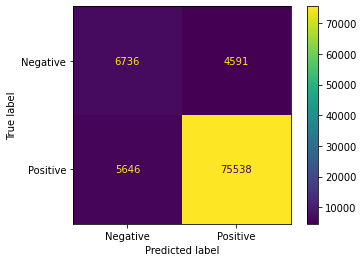

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_actual, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negative','Positive'])

cm_display.plot()
plt.show()

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, 3),max_features=2000)

In [ ]:
x_tf_train = tfidf.fit_transform(input_train)

In [ ]:
features = tfidf.get_feature_names_out()

In [ ]:
features

array(['ability', 'able', 'able book', ..., 'york', 'young', 'zero'],
      dtype=object)

In [ ]:
input_test

array(['good experience purchasing wish website date trust worthy look compare priceline expedia etc also comfortable almost hr delay receive confirm flight info',
       'justfly web site easy navigate provide appear good value money ',
       'anjali fantastic helpful', ...,
       'everything go well first register line make payment receive proof purchase form barcode problems parking transportation airport come time retrieve vehicle show park attendant barcode smartphone show proof purchase park attendant give hard way go say barcode good another park attend chime say know barcode legit website start get upset park attendants go back forth issue suddenly check personal bank statement online show withdrawal wallypark show proof let go words apologies explanations part dispute felt though try scam make pay twice know computer flaw system would leniency part come online purchases want report complaint incident get sidetrack receive email give feedback experience wallypark shame normal

In [ ]:
x_tf_test = tfidf.transform(input_test)

In [ ]:
sm = SMOTE(random_state=50)
X_res, y_res = sm.fit_resample(x_tf_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
uni, counts = np.unique(y_res,return_counts=True)

In [ ]:
uni, counts

(array([0, 1]), array([189916, 189916]))

In [ ]:
x_tf_train.shape

(215857, 2000)

In [ ]:
X_res.shape

(379832, 2000)

In [ ]:
classifier2 = MultinomialNB()
classifier2.fit(X_res, y_res)

MultinomialNB()

In [ ]:
y_res_train_pred = classifier2.predict(X_res)

In [ ]:
y_res_test_pred = classifier2.predict(x_tf_test)

In [ ]:
classifier2.score(X_res,y_res)

0.7749505044335391

In [ ]:
classifier2.score(x_tf_test,y_actual)

0.7963809709115672

In [ ]:
f = open('my_classifier.pickle', 'wb')
pickle.dump(classifier2, f)
f.close()

In [ ]:
print(classification_report(y_actual,y_res_test_pred))

              precision    recall  f1-score   support

           0       0.34      0.74      0.47     11327
           1       0.96      0.80      0.87     81184

    accuracy                           0.80     92511
   macro avg       0.65      0.77      0.67     92511
weighted avg       0.88      0.80      0.82     92511



In [ ]:
with open('my_classifier.pickle','rb') as f:
  model = pickle.load(f)

In [ ]:
model.predict(vectorized)[0]

0

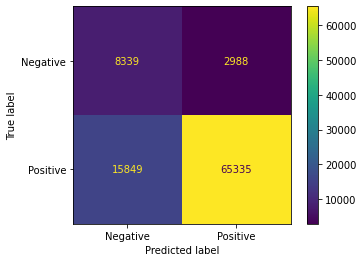

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_actual, y_res_test_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negative','Positive'])

cm_display.plot()
plt.show()

In [ ]:
resultant = pd.DataFrame(data = {'Comments':input_test ,'True Labels': y_actual,'Predicted Labels': y_res_test_pred})

In [ ]:
resultant.head()

,Comments,True Labels,Predicted Labels
0,good experience purchasing wish website date t...,0,1
1,justfly web site easy navigate provide appear ...,1,1
2,anjali fantastic helpful,1,1
3,experience come lot excellent individual nice ...,1,0
4,receive email specific flight open email check...,0,0


In [ ]:
columns = ['Features', 'Positive_Probability', 'Negative_Probability']

In [ ]:
features = features.reshape(-1,1)

In [ ]:
features

array([['ability'],
       ['able'],
       ['able book'],
       ...,
       ['york'],
       ['young'],
       ['zero']], dtype=object)

In [ ]:
classifier2.predict_proba(X_res)

array([[0.55098573, 0.44901427],
       [0.97585611, 0.02414389],
       [0.11087585, 0.88912415],
       ...,
       [0.30731553, 0.69268447],
       [0.96208415, 0.03791585],
       [0.39154362, 0.60845638]])

In [ ]:
prob = classifier2.predict_proba(X_res)

In [ ]:
X_res

<379832x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 8686607 stored elements in Compressed Sparse Row format>

In [ ]:
features = features.reshape(-1)

In [ ]:
features

array(['ability', 'able', 'able book', ..., 'york', 'young', 'zero'],
      dtype=object)

In [ ]:
test =x_tf_test.toarray()

In [ ]:
test_data = pd.DataFrame(data=test)

In [ ]:
test_data

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.142154,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92506,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
92507,0.188969,0.108583,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
92508,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
92509,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.038384,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
pipe = make_pipeline(tfidf, classifier2)

In [ ]:
df1.comment.iloc[0]

"we have always been pleased with our Just Fly experiences.   The prices and the alerts - it's our go to when planning travel."

In [ ]:
print(pipe.predict_proba([df1.clean_comment.iloc[0]]))

[[0.24829506 0.75170494]]


In [ ]:
explainer = LimeTextExplainer(class_names = ['Negative','Positive'])

In [ ]:
max_features = df1.clean_comment.str.split().map(lambda x: len(x)).max()

In [ ]:
print(max_features)

1287


In [ ]:


random.seed(18)
idx = random.randint(0, len(df1))

In [ ]:
df1.comment.iloc[idx]

'very quick and easy to get a reservation!'

In [ ]:
df1.comment.iloc[5]

'Its my first time flying, so I hope to have the pleasure of flying comfortably.'

In [ ]:
exp = explainer.explain_instance("such a wonderful service, high prices, no refunds, witty customer suport", pipe.predict_proba, num_features = 10)

In [ ]:
exp.as_list()

[('wonderful', 0.17969428829581088),
 ('prices', 0.08031467058939544),
 ('high', -0.046551656101664694),
 ('customer', -0.03638689989643501),
 ('service', 0.012532798576191159),
 ('suport', -0.001209202780877154),
 ('a', 0.001112943163923633),
 ('no', -0.0005972685106525159),
 ('witty', -0.0001822876653530189),
 ('refunds', -0.00013793815547699556)]

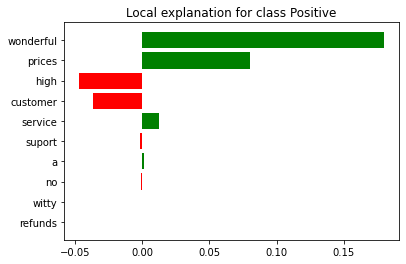

In [ ]:
f = exp.as_pyplot_figure()

In [ ]:
exp.show_in_notebook(text=True)

In [ ]:
live_review= {'Comment':"I'm very happy To find JUSTFLY. We went from paying $560 for round trip to less the $200 for same tickets. We will never use any other service except JUSTFLY"}

In [ ]:
live_df = pd.DataFrame(data=live_review, index=[0])

In [ ]:
vectorized = tfidf.transform(numpy.array(["I'm very happy To find JUSTFLY. We went from paying $560 for round trip to less the $200 for same tickets. We will never use any other service except JUSTFLY"]))

In [ ]:
vect = tfidf.transform(df1.clean_comment)

In [ ]:
classifier3 = MultinomialNB()
classifier3.fit(vect, df1.Target)

MultinomialNB()

In [ ]:
y_test = classifier3.predict(x_tf_test)

In [ ]:
print(classification_report(y_actual,y_test))

              precision    recall  f1-score   support

           0       0.61      0.49      0.54     11327
           1       0.93      0.96      0.94     81184

    accuracy                           0.90     92511
   macro avg       0.77      0.72      0.74     92511
weighted avg       0.89      0.90      0.89     92511



In [ ]:
prediction = classifier2.predict(vectorized)

In [ ]:
prediction[0]

1

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stops = stopwords.words('english')

In [ ]:
stops

In [ ]:
vectorizer = CountVectorizer(stop_words=stops, ngram_range= (1,1))

In [ ]:
df1

,Unnamed: 0.1,Unnamed: 0,comment,label,clean_comment,Target
0,0,0,"Mohammad harun, he is an awesome guy very info...",Postive,mohammad harun awesome guy informative helpful...,1
1,1,1,"amazing guy gaurav was, so patience and kind. ...",Postive,amaze guy gaurav patience kind help start end ...,1
2,2,2,Gaurav was very knowledgeable and very helpful...,Postive,gaurav knowledgeable helpful know situation ab...,1
3,3,3,I called them regarding my flight cancellation...,Postive,call regard flight cancellation narrate worrie...,1
4,4,4,VERY GOOD SERVICE BY GAURAV LOHAT SERVED AS SO...,Postive,good service gaurav lohat serve soon reach tra...,1
...,...,...,...,...,...,...
308379,308379,308379,You have to double check price before place or...,Postive,double check price place order may auto jump d...,1
308380,308380,308380,My reserved flight was just as I expected. Th...,Postive,reserve flight expected justfly website work w...,1
308381,308381,308381,Quick easy and cheap.,Postive,quick easy cheap,1
308382,308382,308382,Great experience & price,Postive,great experience price,1


In [ ]:
X = vectorizer.fit_transform(df1['clean_comment'].apply(lambda x: np.str_(x)))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
lda = LatentDirichletAllocation(
    n_components=5,
    random_state = 777
)

In [ ]:
lda.fit(X)

KeyboardInterrupt: ignored

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/lda_sk_bi.pkl', 'wb') as f:
  pickle.dump(lda, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/lda_sk.pkl', 'rb') as f:
  lda = pickle.load(f)

In [ ]:
def plot_top_words(model, feature_names, n_top_words=20,title='LDA'):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
feature_names = vectorizer.get_feature_names_out()

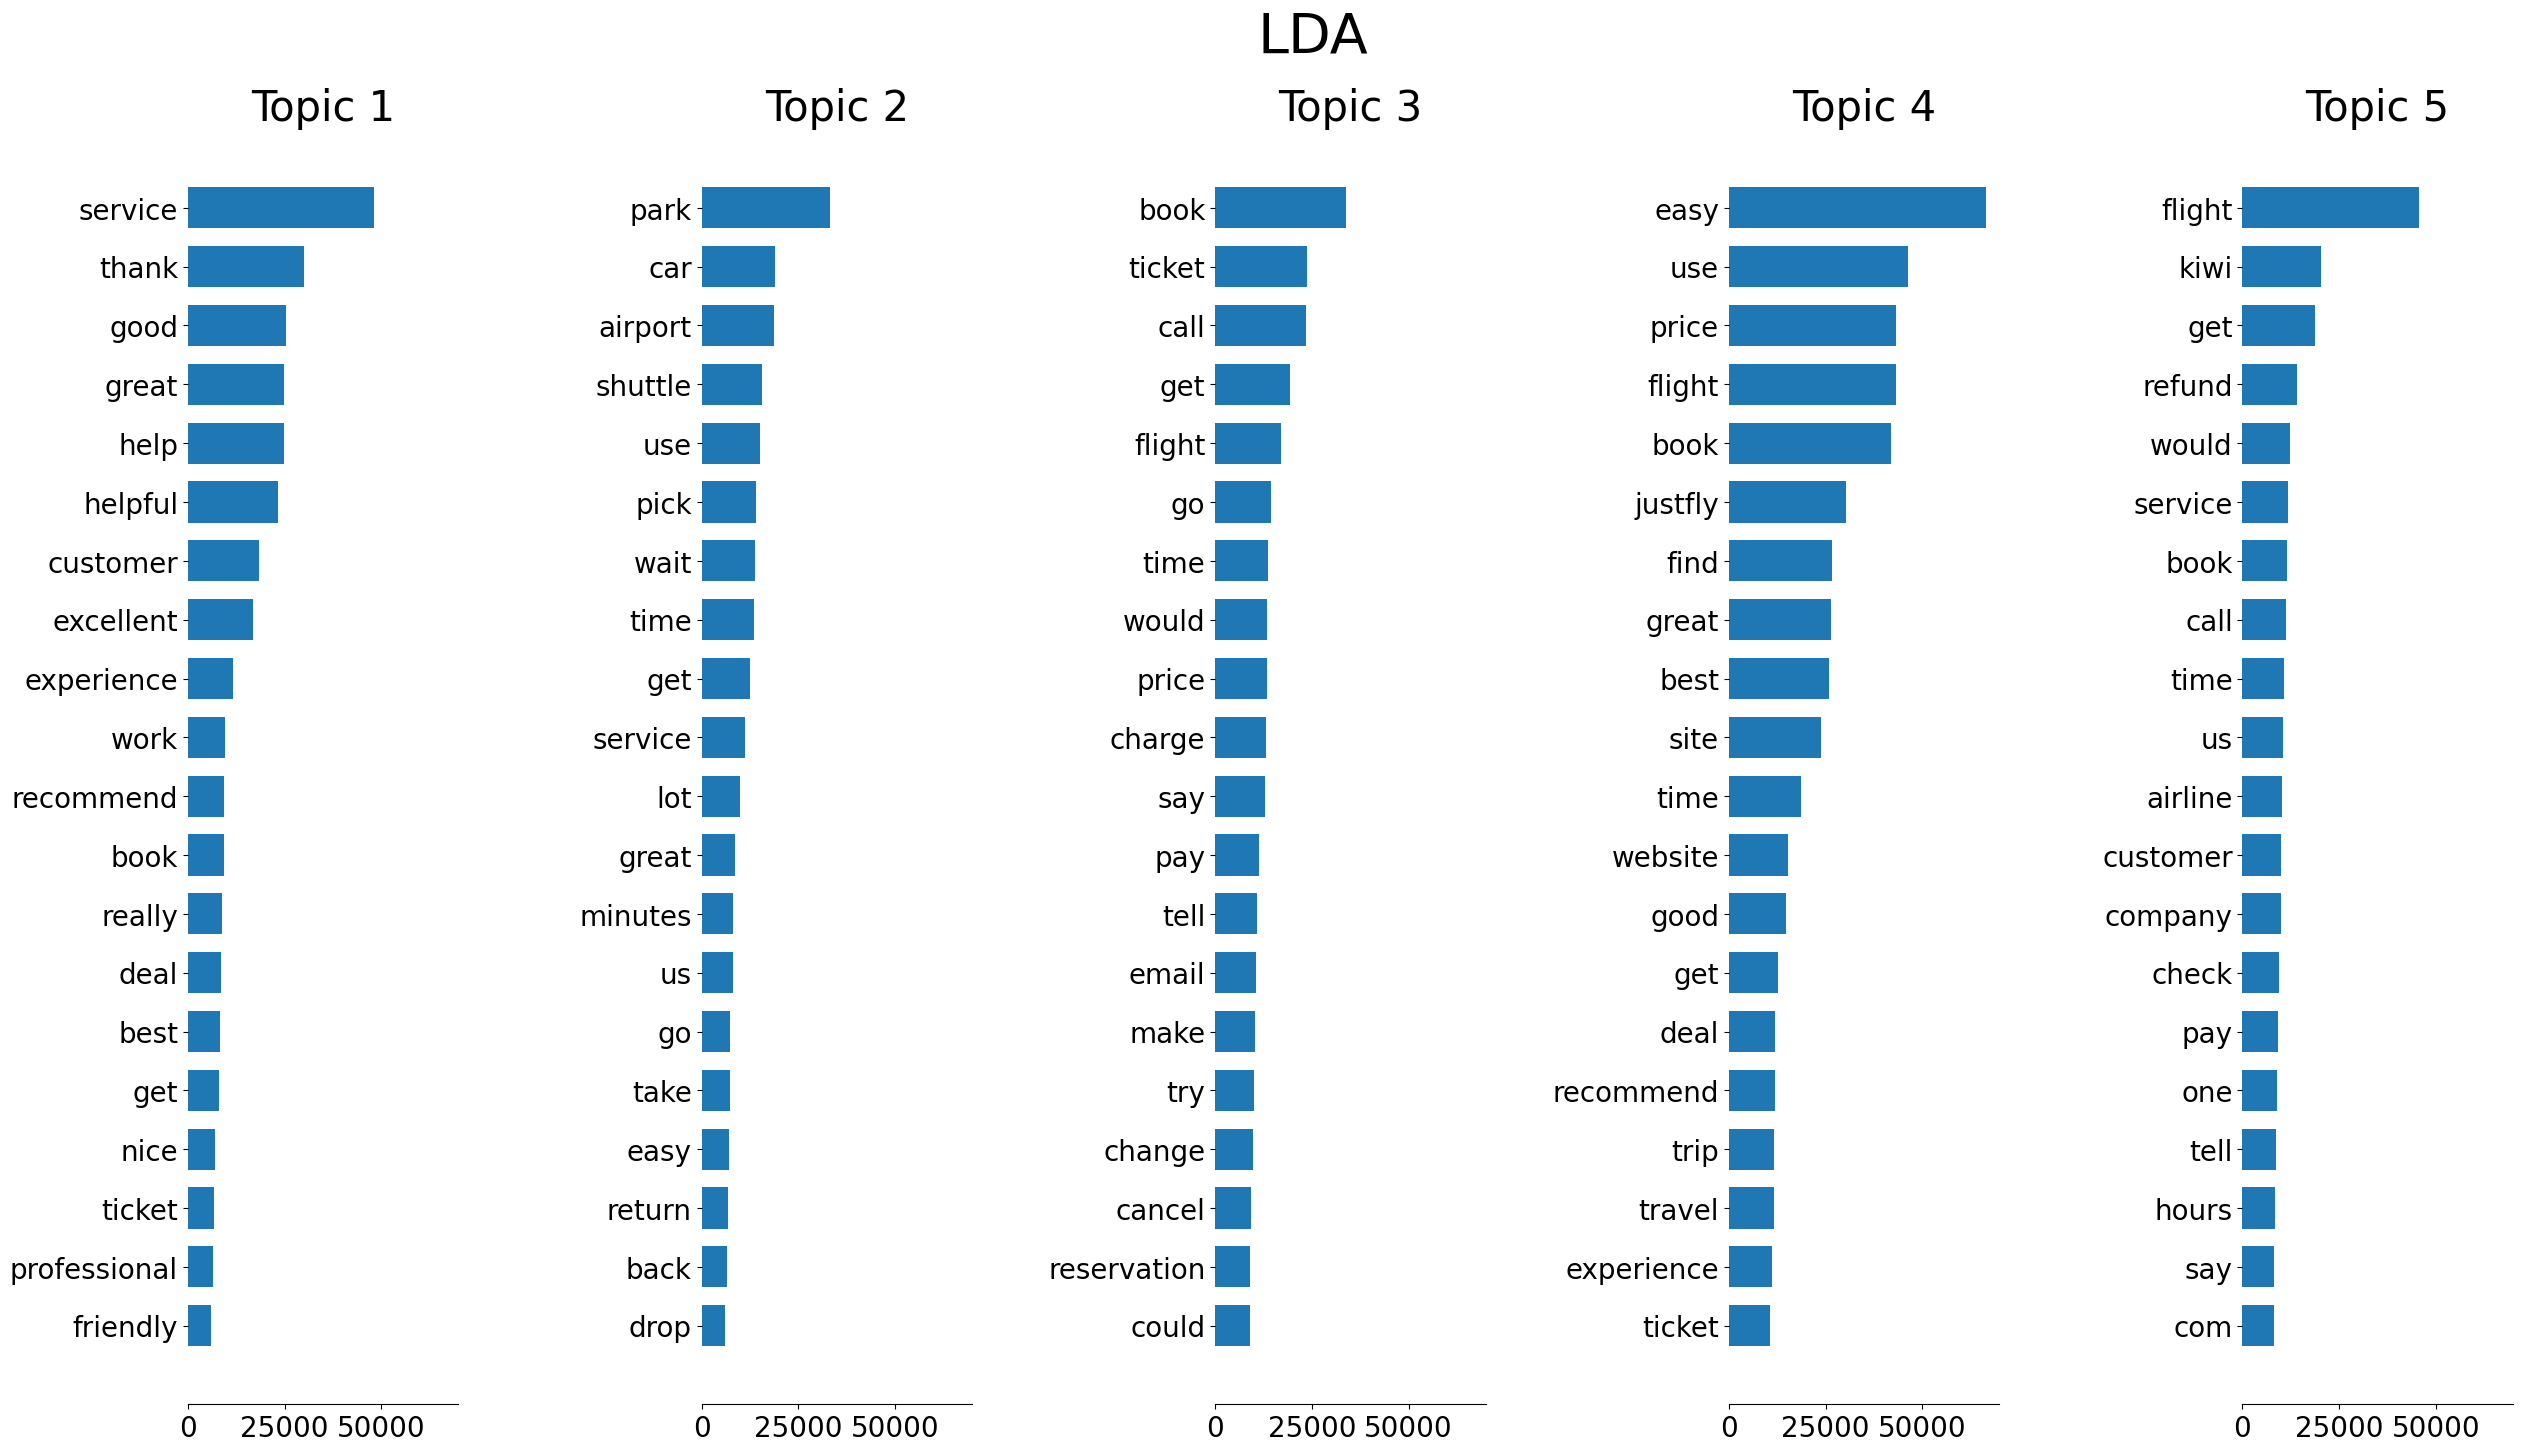

In [ ]:
plot_top_words(lda,feature_names)


1.   Topic 1: Customer Service
2.   Topic 2: Shuttle service and car parking
3.   Topic 3: Pricing, Booking and Cancellations
4.   Topic 4: UI interface
5.   Topic 5: Refunds Service








In [ ]:
Z = lda.transform(X)

In [ ]:
Z.shape

(308384, 5)

In [ ]:
np.random.seed(0)

In [ ]:
i = np.random.choice()

TypeError: ignored

In [ ]:
df1.head()

,Unnamed: 0.1,Unnamed: 0,comment,label,clean_comment,Target
0,0,0,"Mohammad harun, he is an awesome guy very info...",Postive,mohammad harun awesome guy informative helpful...,1
1,1,1,"amazing guy gaurav was, so patience and kind. ...",Postive,amaze guy gaurav patience kind help start end ...,1
2,2,2,Gaurav was very knowledgeable and very helpful...,Postive,gaurav knowledgeable helpful know situation ab...,1
3,3,3,I called them regarding my flight cancellation...,Postive,call regard flight cancellation narrate worrie...,1
4,4,4,VERY GOOD SERVICE BY GAURAV LOHAT SERVED AS SO...,Postive,good service gaurav lohat serve soon reach tra...,1


In [ ]:
df1['comment'][0]

'Mohammad harun, he is an awesome guy very informative and helpful. He helped me in booking my flight to india in a emergency situation and he finished all the formalities for me. I am really thankful to him and his team. You Rock Harun'

In [ ]:
Z[0]

array([0.88311158, 0.01001922, 0.01015804, 0.01027481, 0.08643635])

In [ ]:
z=Z[i]

NameError: ignored

In [ ]:
topic_label = []
for i in range(0,len(df1)):
  z = Z[i]
  topic = np.array(z).argmax()+1
  topic_label.append(topic)

In [ ]:
df1['Topic'] = topic_label

array([[<Axes: title={'center': 'Topic'}>]], dtype=object)

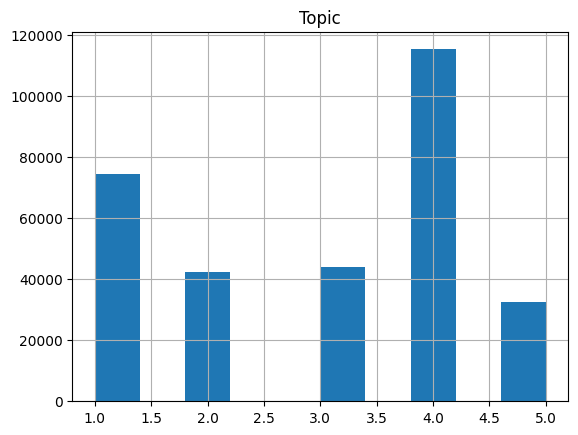

In [ ]:
df1.hist('Topic')

In [ ]:
df1.head()

,Unnamed: 0.1,Unnamed: 0,comment,label,clean_comment,Target,Topic
0,0,0,"Mohammad harun, he is an awesome guy very info...",Postive,mohammad harun awesome guy informative helpful...,1,1
1,1,1,"amazing guy gaurav was, so patience and kind. ...",Postive,amaze guy gaurav patience kind help start end ...,1,1
2,2,2,Gaurav was very knowledgeable and very helpful...,Postive,gaurav knowledgeable helpful know situation ab...,1,1
3,3,3,I called them regarding my flight cancellation...,Postive,call regard flight cancellation narrate worrie...,1,5
4,4,4,VERY GOOD SERVICE BY GAURAV LOHAT SERVED AS SO...,Postive,good service gaurav lohat serve soon reach tra...,1,1


In [ ]:
df_Topic1 = df1[df1['Topic'] ==1]
df_Topic2 = df1[df1['Topic'] ==2]
df_Topic3 = df1[df1['Topic'] ==3]
df_Topic4 = df1[df1['Topic'] ==4]
df_Topic5 = df1[df1['Topic'] ==5]

In [ ]:
df1.groupby('Target').count()

,Unnamed: 0.1,Unnamed: 0,comment,label,clean_comment,Topic
Target,,,,,,
0,37271,37271,37268,37271,37266,37271
1,271113,271113,271100,271113,271081,271113


In [ ]:
df_Topic1.groupby('Target').count()

,Unnamed: 0.1,Unnamed: 0,comment,label,clean_comment,Topic
Target,,,,,,
0,2918,2918,2915,2918,2913,2918
1,71582,71582,71569,71582,71550,71582


In [ ]:
df_Topic2.groupby('Target').count()

,Unnamed: 0.1,Unnamed: 0,comment,label,clean_comment,Topic
Target,,,,,,
0,4595,4595,4595,4595,4595,4595
1,37815,37815,37815,37815,37815,37815


In [ ]:
df_Topic3.groupby('Target').count()

,Unnamed: 0.1,Unnamed: 0,comment,label,clean_comment,Topic
Target,,,,,,
0,11379,11379,11379,11379,11379,11379
1,32394,32394,32394,32394,32394,32394


In [ ]:
df_Topic4.groupby('Target').count()

,Unnamed: 0.1,Unnamed: 0,comment,label,clean_comment,Topic
Target,,,,,,
0,5096,5096,5096,5096,5096,5096
1,110079,110079,110079,110079,110079,110079


In [ ]:
df_Topic5.groupby('Target').count()

,Unnamed: 0.1,Unnamed: 0,comment,label,clean_comment,Topic
Target,,,,,,
0,13283,13283,13283,13283,13283,13283
1,19243,19243,19243,19243,19243,19243



```
Topic 1: Customer Service
Topic 2: Shuttle service and car parking
Topic 3: Pricing, Booking and Cancellations
Topic 4: UI interface
Topic 5: Refunds Service

 Topic    Total Reviews	  Positive Reviews	    Negative Reviews
Topic 1	   74,500(24%)	          71,582 (96%)	       2,918 (4%)
Topic 2	   42,410(14%)	          37,815 (89%)	       4,595 (11%)
Topic 3       43,773(15%)	          32,394 (74%)	       11,379 (26%)
Topic 4	   115,175(37%)	        110,079 (96%)	       5,096 (4%)
Topic 5	   32,526(10%)	          19,243 (59%)	       13,283 (41%)
Total	     308,384	        271,113 (88%)	       37,271 (12%)

```



Total Reviews = Topic_1 + Topic_2 + Topic_3 + Topic_4 + Topic_5
<hr>
308384    = 74500 (24%) + 42410(14%) + 43773(15%) + 115175(37%) + 32526(10%)
<hr>
Total  = 308384<br>
Positive = 271113(88%)<br>
Negative = 37271(12%)
<br>
<hr>
Topic 1 Total = 74500<br>
Positive = 71582 (96%)<br> 
Negative = 2918 (4%)
<hr>
Topic 2 Total = 42410<br>
Positive = 37815(89%)<br> 
Negative = 4595(11%)
<hr>
Topic 3 Total = 43773<br>
Positive = 32394(74%)<br> 
Negative = 11379(26%)
<hr>
Topic 4 Total = 115175<br>
Positive = 110079(96%)<br> 
Negative = 5096(4%)
<hr>
Topic 5 Total = 32526<br>
Positive = 19243(59%)<br> 
Negative = 13283(41%)
<hr>

In [ ]:
32526/308384

0.10547239804918543

In [ ]:
topics = np.arange(5)+1

Text(0.5, 1.0, 'True Labels: 1')

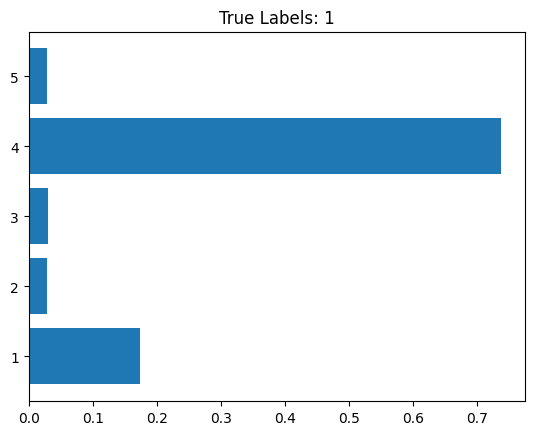

In [ ]:
fig, ax = plt.subplots()

ax.barh(topics,z)
ax.set_yticks(topics)
ax.set_title('True Labels: %s' %df1.iloc[i]['Target'])

In [ ]:
import textwrap

In [ ]:
def wrap(x):
  return textwrap.fill(x, replace_whitespace=False, fix_sentence_endings=True)

print(wrap(df1.iloc[i]['comment']))

Site was very easy to review and access.  Booking was very
accommodating.
